In [1]:

import os
import os
import random
import torch
import cv2
import numpy as np
from lungmask import mask
import SimpleITK as sitk
import torchvision.transforms as transforms
from scipy.ndimage.filters import median_filter
import pydicom
from torch.utils.data import Dataset

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torch.nn.functional as F
import random
from itertools import combinations, product
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


C:\Users\Nimesha\AppData\Local\Temp\ipykernel_20932\3064484526.py:10: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


In [2]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def get_mask(filename, plot_mask=False, return_val=False):

    input_image = sitk.ReadImage(filename)
    mask_out = mask.apply(input_image)[0]  #default model is U-net(R231)

    if return_val:
        return mask_out

def preprocess_images(img,dicom_image):

    hu_image = transform_to_hu(dicom_image, img)
    filtered_image = median_filter(hu_image, size=(3, 3))
    return filtered_image

In [3]:
class DICOMDataset(Dataset):

   def __init__(self, root_dir ,transform=None):

      self.img_labels = []
      self.root_dir = root_dir
      self.dcm_files = os.listdir(root_dir)

      # Group images by category
      categories = {'A': 1, 'B': 2, 'G': 3, 'E': 4}
      category_images = {category: [] for category in categories}

      for filename in os.listdir(root_dir):
            image_name = filename
            category = image_name[0]
            if category in categories:
                category_images[category].append(image_name)

      
      # Create pairs of images from the same category or different categories
      for category, images in category_images.items():
         # Same category pairs
         same_category_pairs = list(combinations(images, 2))
         same_category_labels = [1] * len(same_category_pairs)
         self.img_labels.extend(zip(same_category_pairs, same_category_labels))

         # Different category pairs
         for other_category, other_images in category_images.items():
            if other_category != category:
                  different_category_pairs = list(product(images, other_images))
                  different_category_labels = [0] * len(different_category_pairs)
                  self.img_labels.extend(zip(different_category_pairs, different_category_labels))
            
      # Shuffle the image labels
      random.shuffle(self.img_labels)
   

   def __getitem__(self, index):
        img_pair, label = self.img_labels[index]

        img1_path, img2_path = img_pair

        img1 = os.path.join(self.root_dir, img1_path)
        img2 = os.path.join(self.root_dir, img2_path)

        dicom_image1= pydicom.dcmread(img1)
        image1 = np.array(dicom_image1.pixel_array)

        dicom_image2= pydicom.dcmread(img2)
        image2 = np.array(dicom_image2.pixel_array)

        cleaned_image1 = preprocess_images(image1,dicom_image1)
        masked_img1=get_mask(img1,plot_mask=True,return_val=True)

        cleaned_image2 = preprocess_images(image2,dicom_image2)
        masked_img2=get_mask(img2,plot_mask=True,return_val=True)

        mask_on_orginal1 = cleaned_image1 * masked_img1
        mask_on_orginal1 = cv2.resize(mask_on_orginal1, (224, 224))


        mask_on_orginal2 = cleaned_image2 * masked_img2
        mask_on_orginal2 = cv2.resize(mask_on_orginal2, (224, 224))

        image1 = mask_on_orginal1.astype('float32')
        image1 = np.expand_dims(image1, axis=0)

        image2 = mask_on_orginal2.astype('float32')
        image2 = np.expand_dims(image2, axis=0)
       
        image1 = torch.from_numpy(image1)
        image2 = torch.from_numpy(image2)
        print(label)
        return image1,image2, label
   
   def __len__(self):
        # print(len(self.img_labels))
        return len(self.img_labels)
       


In [4]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
          
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Calculate output shape of the convolutional layers
        conv_output_shape = self.cnn1(torch.zeros(1, *(1, 224, 224))).shape

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3], 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        
       
        #  This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

       

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [5]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [12]:
siamese_dataset = DICOMDataset(root_dir='../IMAGES/TRAIN_SET/', transform=None)

# Create a simple dataloader just for simple visualization
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0 ,batch_size= 8)
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001 )

In [13]:
counter = []
loss_history = [] 
iteration_number= 0

# # Iterate throught the epochs
for epoch in range(3):
    print( "Episode" + str(epoch))
    #  Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        

        # Zero the gradients
        optimizer.zero_grad()
   
        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)


         # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 5  batches print out the loss
        if i % 10 == 0 :
          
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())




Episode0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2009.25it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0
Epoch number 0
 Current loss 14.539315223693848



100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<00:00, 1195.75it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 4/4 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.31it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1992.54it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 4/4 [00:00<00:00, 7981.55it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 1997.29it/s]


0


100%|██████████| 4/4 [00:00<00:00, 3992.67it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4015.61it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5018.31it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1934.20it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10036.62it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.80it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1
Epoch number 0
 Current loss 1660.397705078125



100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2009.25it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1981.25it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3005.23it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1990.18it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4010.81it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2002.53it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1288.37it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 1997.60it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.74it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 1331.10it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.10it/s]


0


100%|██████████| 10/10 [00:00<00:00, 5009.92it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1607.94it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1332.37it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5019.51it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0
Epoch number 0
 Current loss 407.1123352050781



100%|██████████| 3/3 [00:00<00:00, 2882.68it/s]


0


100%|██████████| 10/10 [00:00<00:00, 5006.93it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2002.53it/s]


0


100%|██████████| 4/4 [00:00<00:00, 3998.38it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4006.02it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<00:00, 2889.97it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 3837.42it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2980.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4015.61it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.11it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 4986.10it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2923.54it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5014.71it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3011.71it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1330.47it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1
Epoch number 0
 Current loss 103.24604034423828



100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5014.71it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 3/3 [00:00<00:00, 1998.24it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


0


100%|██████████| 5/5 [00:00<00:00, 4960.15it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 1987.35it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1330.47it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.99it/s]


1


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5006.33it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4016.57it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5015.91it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 4/4 [00:00<00:00, 2661.78it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.11it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3014.59it/s]


0


100%|██████████| 2/2 [00:00<00:00, 3990.77it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3006.67it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10036.62it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2010.21it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1904.34it/s]


0
Epoch number 0
 Current loss 53.995487213134766



100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 3856.83it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4011.77it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 3990.77it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


1


100%|██████████| 5/5 [00:00<00:00, 5011.12it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4010.81it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1366.22it/s]


0


100%|██████████| 4/4 [00:00<00:00, 2004.21it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 2911.19it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2085.68it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2003.49it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 10/10 [00:00<00:00, 5029.14it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.77it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5250.76it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2015.04it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2003.49it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3007.39it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2004.93it/s]


0
Epoch number 0
 Current loss 20.040193557739258



100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10031.82it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3013.15it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2009.73it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 9250.78it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5013.51it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4017.53it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2621.44it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.53it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.99it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 3914.42it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 5921.37it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2004.93it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3007.39it/s]


1


100%|██████████| 5/5 [00:00<00:00, 3338.35it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4010.81it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0
Epoch number 0
 Current loss 14.842650413513184



100%|██████████| 4/4 [00:00<00:00, 3986.03it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3134.76it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5018.31it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 5513.98it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10034.22it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2003.01it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3011.71it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2003.49it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10034.22it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3013.87it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3011.71it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3010.99it/s]


1


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0
Epoch number 0
 Current loss 7.283676624298096



100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.95it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5019.51it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.53it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4015.61it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4007.94it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 1911.72it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 3991.53it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1829.58it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2009.25it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 1501.18it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5015.91it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1986.88it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0
Epoch number 0
 Current loss 3.7634522914886475



100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4014.65it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1998.24it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.11it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2990.95it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1332.37it/s]


0


100%|██████████| 4/4 [00:00<00:00, 3449.26it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 9967.45it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2887.31it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1990.65it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.80it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4006.98it/s]


1


100%|██████████| 5/5 [00:00<00:00, 9845.78it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.77it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10027.02it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1386.55it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3012.43it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10029.42it/s]


0
Epoch number 0
 Current loss 2.2300872802734375



100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.53it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4010.81it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 3/3 [00:00<00:00, 1998.56it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1991.12it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 4/4 [00:00<00:00, 4014.65it/s]


0


100%|██████████| 3/3 [00:00<00:00, 1996.65it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<00:00, 3726.61it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5020.71it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2003.01it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5015.91it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0
Epoch number 0
 Current loss 1.094072937965393



100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2236.17it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3011.71it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3015.32it/s]


1


100%|██████████| 2/2 [00:00<00:00, 1332.16it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 3988.88it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4008.89it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2001.58it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2009.25it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3010.99it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.80it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2001.58it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2003.97it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4011.77it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<00:00, 2645.69it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4008.89it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10034.22it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4014.65it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3012.43it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5015.91it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4011.77it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


1


100%|██████████| 4/4 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2007.80it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0
Epoch number 0
 Current loss 1.2658425569534302



100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3010.27it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4015.61it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10029.42it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2009.25it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2988.11it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 2643.47it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.80it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


1


100%|██████████| 4/4 [00:00<00:00, 4016.57it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1369.12it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<00:00, 2009.25it/s]


0


100%|██████████| 5/5 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]


0


100%|██████████| 4/4 [00:00<00:00, 3976.59it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 4/4 [00:00<00:00, 4014.65it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


0


100%|██████████| 2/2 [00:00<00:00, 3687.30it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3012.43it/s]


0


100%|██████████| 4/4 [00:00<00:00, 3643.26it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 3990.77it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


100%|██████████| 4/4 [00:00<00:00, 4013.69it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1331.95it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0
Epoch number 0
 Current loss 1.7982804775238037



100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 5/5 [00:00<00:00, 5014.71it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


1


100%|██████████| 3/3 [00:00<00:00, 3010.99it/s]


0


100%|██████████| 2/2 [00:00<00:00, 1460.92it/s]


1


100%|██████████| 2/2 [00:00<?, ?it/s]


0


100%|██████████| 5/5 [00:00<00:00, 5017.11it/s]


0


100%|██████████| 10/10 [00:00<00:00, 10017.44it/s]


0


100%|██████████| 2/2 [00:00<?, ?it/s]


1


100%|██████████| 3/3 [00:00<?, ?it/s]


0


100%|██████████| 2/2 [00:00<00:00, 2006.84it/s]


0


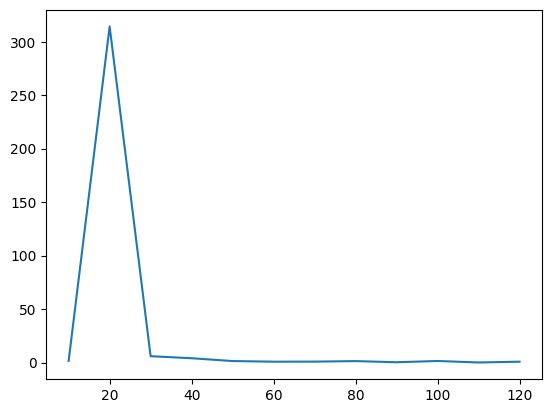

In [9]:
import matplotlib.pyplot as plt
plt.plot(counter, loss_history)
plt.show()

In [10]:
test_dataset = DICOMDataset(root_dir='../IMAGES/TEST_SET/', transform=None)

# Create a simple dataloader just for simple visualization
test_dataloader = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0)


In [11]:
import torchvision

# Initialize variables to store true positives, true negatives, false positives, and false negatives
true_positives = 0.000000000000001
true_negatives = 0.000000000000001
false_positives = 0.00000000000001
false_negatives = 0.00000000000001
threshold = 0.8




# # Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)



for i in range(10):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, label2 = next(dataiter)
 
    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), dim=3)

    # Convert the concatenated tensor to a numpy array
    concatenated_np = concatenated.squeeze().numpy()
    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)

    if label2==torch.FloatTensor([[1]]):
       status ="DICOM pair comes from same lung cancer type"
    else :
       status ="DICOM  pair comes from different lung cancer types"
    print("Truth" + status)

    # Determine the predicted status based on the euclidean distance
    if euclidean_distance < threshold:  # You need to determine an appropriate threshold
        predicted_status = "DICOM pair comes from same lung cancer type"
    else:
        predicted_status = "DICOM pair comes from different lung cancer types"
    print("Predicted" +predicted_status)

   # Compare predicted status with true status and update counters
    if predicted_status == status:
        if status == "DICOM pair comes from same lung cancer type":
            true_positives += 1
            print(true_positives)
        else:
            true_negatives += 1
    else:
        if status == "DICOM pair comes from same lung cancer type":
            false_negatives += 1
        else:
            false_positives += 1

      
   
    # print(status)
    # plt.imshow(concatenated_np,cmap="ocean")
    # plt.title(f'{status}\nDissimilarity: {euclidean_distance.item():.2f}')

    # plt.axis('off')
    # plt.show()

    

    # if label2==torch.FloatTensor([[0]])  and  euclidean_distance >= 1.5 :
    #    break
      
# Calculate performance metrics
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives +false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)











   
    
    
    
    

100%|██████████| 2/2 [00:00<00:00, 2008.29it/s]


0


100%|██████████| 3/3 [00:00<00:00, 3011.71it/s]


0
TruthDICOM  pair comes from different lung cancer types
PredictedDICOM pair comes from different lung cancer types


100%|██████████| 2/2 [00:00<?, ?it/s]


0
TruthDICOM  pair comes from different lung cancer types
PredictedDICOM pair comes from same lung cancer type


100%|██████████| 2/2 [00:00<?, ?it/s]


0
TruthDICOM  pair comes from different lung cancer types
PredictedDICOM pair comes from same lung cancer type


100%|██████████| 2/2 [00:00<?, ?it/s]


0
TruthDICOM  pair comes from different lung cancer types
PredictedDICOM pair comes from same lung cancer type


100%|██████████| 2/2 [00:00<?, ?it/s]


0
TruthDICOM  pair comes from different lung cancer types
PredictedDICOM pair comes from same lung cancer type


100%|██████████| 3/3 [00:00<00:00, 1505.31it/s]


0
TruthDICOM  pair comes from different lung cancer types
PredictedDICOM pair comes from same lung cancer type
Accuracy: 3.333333333333322e-16
Precision: 1.6666666666666638e-16
Recall: 0.09090909090909091
F1 Score: 3.333333333333322e-16
